In [29]:
import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from torchdyn.datasets import *
from numpy.linalg import norm 
from tqdm import tqdm

In [30]:
import math

def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def normal_sample(n, dim, scale = 5, var=0.001):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    return scale * m.sample((n,))

class MLP(torch.nn.Module):
    def __init__(self, dim, w=512, time_varying=False, depth=3, out_dim=None):
        super().__init__()
        self.time_varying = time_varying
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.LeakyReLU(),
            *([torch.nn.Linear(w, w), torch.nn.LeakyReLU()] * depth),
            torch.nn.Linear(w, dim if out_dim is None else out_dim)
        )

    def forward(self, x):
        return self.net(x)
    



In [31]:
import torchdyn
from torchdyn.core import NeuralODE

class CNF(torch.nn.Module):
    def __init__(self, net, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.net = net
        self.trace_estimator = trace_estimator if trace_estimator is not None else autograd_trace
        self.noise_dist, self.noise = noise_dist, None

    def forward(self, t, x):
        with torch.set_grad_enabled(True):
            x_in = x[:, 1:].requires_grad_(
                True
            )  # first dimension reserved to divergence propagation
            # the neural network will handle the data-dynamics here
            x_out = self.net(torch.cat([x_in, t * torch.ones(x.shape[0], 1)], dim=-1))
            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return (
            torch.cat([-trJ[:, None], x_out], 1) + 0 * x
        )  # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph

    def backward(self, t, x, z):
        with torch.set_grad_enabled(True):
            x_in = x[:, 1:].requires_grad_(
                True
            )  # first dimension reserved to divergence propagation
            # the neural network will handle the data-dynamics here
            x_out = -self.net(torch.cat([x_in, t * torch.ones(x.shape[0], 1)], dim=-1))
            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return (
            torch.cat([-trJ[:, None], x_out], 1) + 0 * x
        )  # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph

In [32]:
import time

# First loss
sigma_min = 0.05
dim = 2
model_h = MLP(dim=dim, time_varying=True)

batch_size = 256
optimizer = torch.optim.Adam(model_h.parameters())

start = time.time()
for k in range(10_000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    
    x0 = eight_normal_sample(batch_size, dim, scale=5, var=0.1).float()
    x1, _ = generate_moons(batch_size, noise=0.2)
    #x1[:, 0] = x1[:, 0] - 0

    # sample some random times
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    M = M / M.max()
    # pi = pot.sinkhorn(a, b, M.detach().cpu().numpy(), reg=0.01)
    pi = pot.emd(a, b, M.detach().cpu().numpy(), 0.01)
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    i, j = np.divmod(choices, pi.shape[1])
    
    mu_t = x0[i] * (1 - t) + x1[j] * t
    sigma_t = sigma_min
    x = mu_t + sigma_t * normal_sample(batch_size, dim).float()
    ut = x1[j] - x0[i]
    vt = model_h(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if k % 100 == 0:
        end = time.time()
        print(f"{k}: loss {loss.item():0.3f} time {(end - start) / 100:0.2f}")
        start = end
        continue

0: loss 8.560 time 0.00
100: loss 0.193 time 0.02
200: loss 0.106 time 0.02
300: loss 0.106 time 0.02
400: loss 0.116 time 0.02
500: loss 0.158 time 0.02
600: loss 0.140 time 0.02
700: loss 0.125 time 0.02
800: loss 0.097 time 0.02
900: loss 0.231 time 0.02
1000: loss 0.105 time 0.02
1100: loss 0.119 time 0.02
1200: loss 0.075 time 0.02
1300: loss 0.092 time 0.02
1400: loss 0.064 time 0.02
1500: loss 0.101 time 0.02
1600: loss 0.092 time 0.02
1700: loss 0.064 time 0.02
1800: loss 0.150 time 0.02
1900: loss 0.103 time 0.02
2000: loss 0.138 time 0.02
2100: loss 0.082 time 0.02
2200: loss 0.113 time 0.02
2300: loss 0.101 time 0.02
2400: loss 0.093 time 0.02
2500: loss 0.065 time 0.02
2600: loss 0.125 time 0.02
2700: loss 0.059 time 0.02
2800: loss 0.096 time 0.02
2900: loss 0.105 time 0.02
3000: loss 0.102 time 0.02
3100: loss 0.106 time 0.02
3200: loss 0.079 time 0.02
3300: loss 0.079 time 0.02
3400: loss 0.055 time 0.02
3500: loss 0.074 time 0.02
3600: loss 0.124 time 0.02
3700: loss 0.

KeyboardInterrupt: 

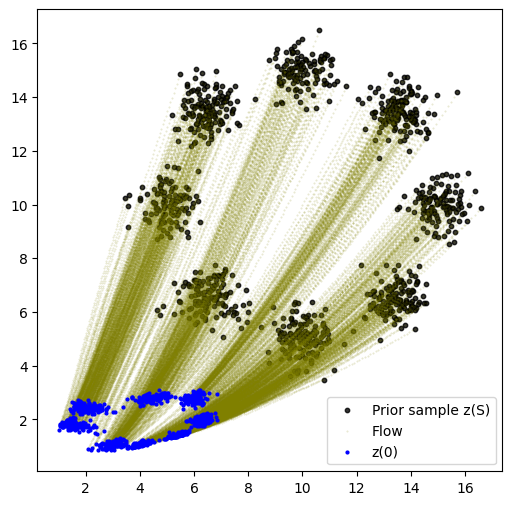

In [36]:

class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))



node_h = NeuralODE(
    torch_wrapper(model_h), solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)
dim = 2

source = eight_normal_sample(1 << 10, dim, scale=5, var=0.1).float() + 10.
full_traj = (
    node_h.trajectory(
        source,
        t_span=torch.linspace(0, 1, 100)
    )
    .detach()
    .cpu()
)
full_traj.shape
traj = full_traj
n = 2000
plt.figure(figsize=(6, 6))
plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()

In [28]:
import time
import itertools

# First loss
sigma_min = 0.05
dim = 2
rep_dim = 128

model_r = MLP(dim=dim, out_dim=rep_dim, time_varying=False)
model_h = MLP(dim=dim + rep_dim, out_dim=dim, time_varying=True)

batch_size = 256
# Combine the parameters from both models
combined_parameters = itertools.chain(model_h.parameters(), model_r.parameters())

# Use the combined parameters in the Adam optimizer
optimizer = torch.optim.Adam(combined_parameters, lr=1e-3)

def get_batch(n=batch_size):
    x0 = eight_normal_sample(n, dim, scale=5, var=0.1).float()
    x1, _ = generate_moons(n, noise=0.2)
    mu = normal_sample(1, dim)
    x0 += mu
    x1 += mu
    return x0, x1

start = time.time()
for k in range(10_000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    x0, x1 = get_batch()

    #x1[:, 0] = x1[:, 0] - 0

    # sample some random times
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    M = M / M.max()
    # pi = pot.sinkhorn(a, b, M.detach().cpu().numpy(), reg=0.01)
    pi = pot.emd(a, b, M.detach().cpu().numpy(), 0.01)
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    i, j = np.divmod(choices, pi.shape[1])
    
    mu_t = x0[i] * (1 - t) + x1[j] * t
    sigma_t = sigma_min
    x = mu_t + sigma_t * normal_sample(batch_size, dim).float()
    ut = x1[j] - x0[i]

    batch_rep = torch.nn.LeakyReLU()(model_r(x0).mean(axis=0)).repeat(batch_size, 1)
    vt = model_h(torch.cat([x, batch_rep, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if k % 100 == 0:
        end = time.time()
        print(f"{k}: loss {loss.item():0.3f} time {(end - start) / 100:0.2f}")
        start = end
        continue

0: loss 8.958 time 0.00
100: loss 1.951 time 0.02
200: loss 1.719 time 0.02
300: loss 2.928 time 0.02
400: loss 1.123 time 0.02
500: loss 0.582 time 0.02
600: loss 1.176 time 0.02
700: loss 0.467 time 0.02
800: loss 1.096 time 0.02
900: loss 0.197 time 0.02
1000: loss 0.479 time 0.02
1100: loss 0.330 time 0.02
1200: loss 1.661 time 0.02
1300: loss 0.882 time 0.02
1400: loss 0.221 time 0.02
1500: loss 0.125 time 0.02
1600: loss 0.382 time 0.02
1700: loss 0.464 time 0.02
1800: loss 0.664 time 0.02
1900: loss 0.979 time 0.02
2000: loss 0.352 time 0.02
2100: loss 0.127 time 0.02
2200: loss 0.242 time 0.02
2300: loss 0.302 time 0.02
2400: loss 0.468 time 0.02
2500: loss 0.278 time 0.02
2600: loss 0.604 time 0.02
2700: loss 0.124 time 0.02
2800: loss 0.118 time 0.02
2900: loss 0.165 time 0.02
3000: loss 0.162 time 0.02
3100: loss 0.674 time 0.02
3200: loss 2.359 time 0.02
3300: loss 0.301 time 0.02
3400: loss 0.174 time 0.02
3500: loss 0.272 time 0.02
3600: loss 0.364 time 0.02
3700: loss 0.

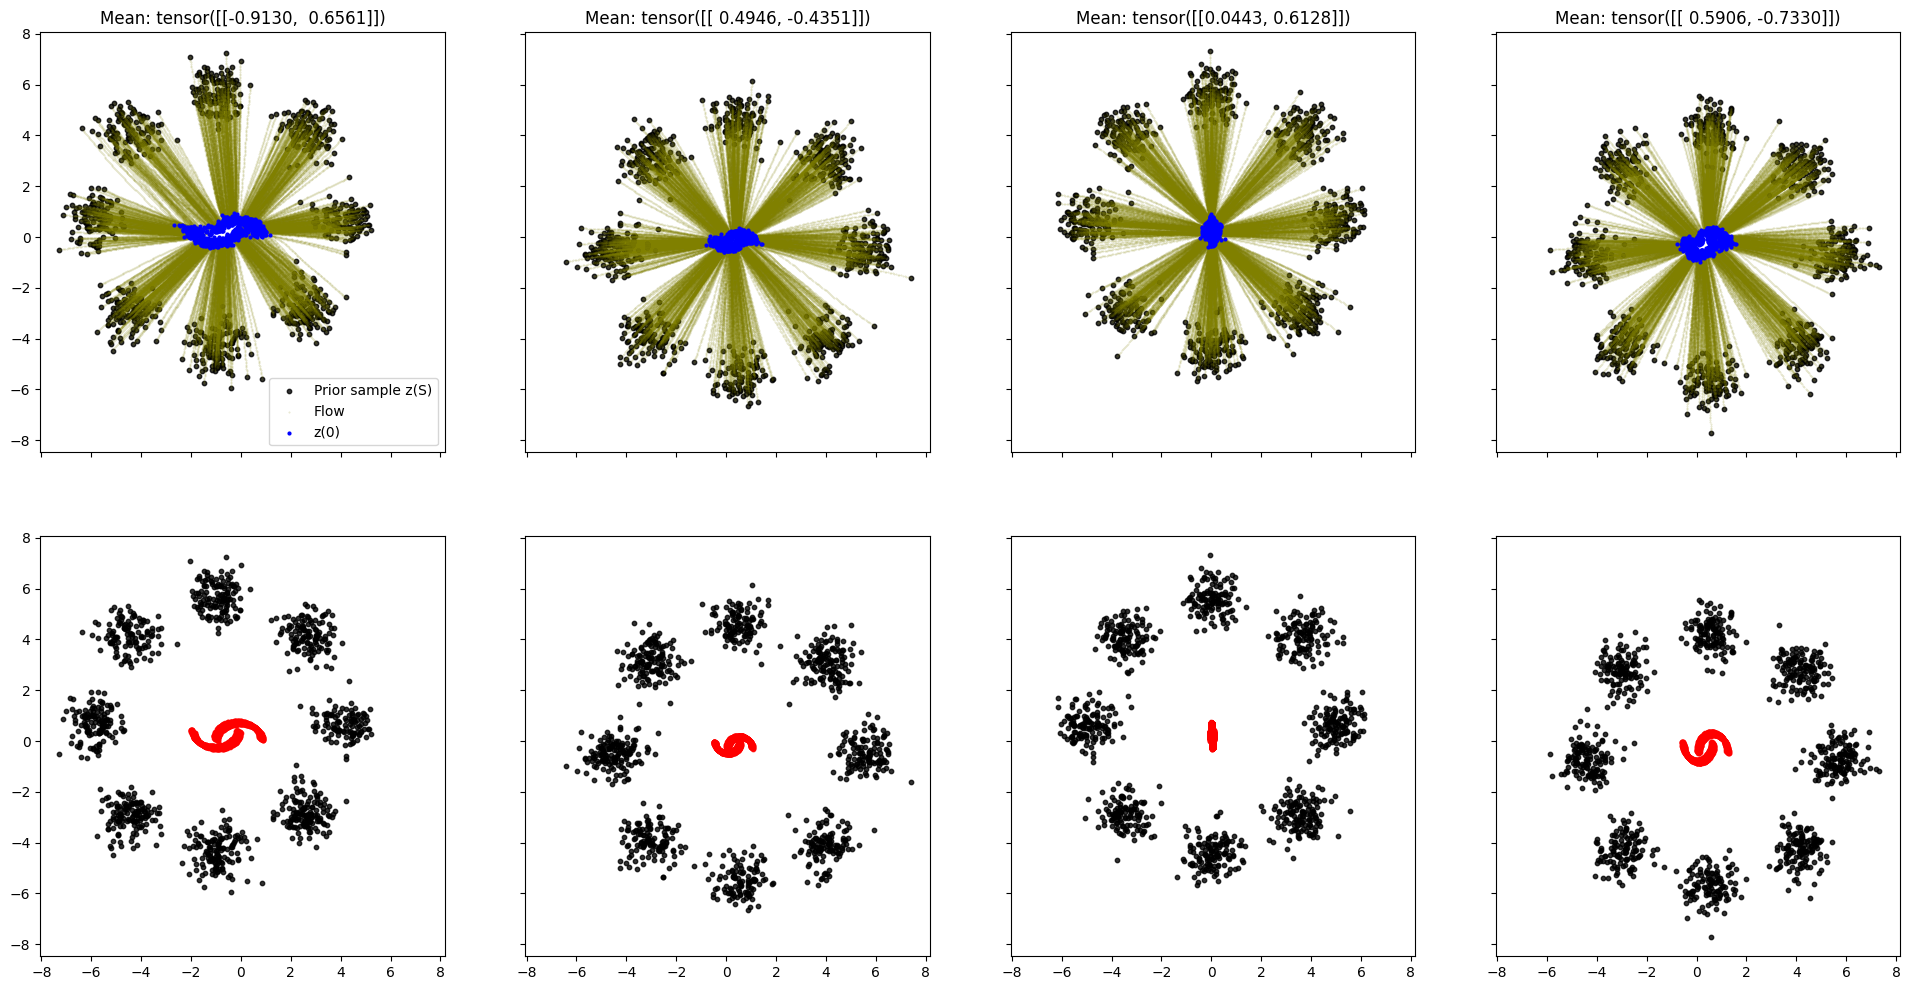

In [18]:

class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.rep = None

    def forward(self, t, x, *args, **kwargs):
        return self.model(torch.cat([x, self.rep, t.repeat(x.shape[0])[:, None]], 1))



wrapper = torch_wrapper(model_h)
node_h = NeuralODE(
    wrapper, solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)
dim = 2
n_source = 1 << 10

num_means = 4

# get figure for three different means
fig, axs = plt.subplots(2, num_means, figsize=(6 * num_means, 6 * 2), sharex=True, sharey=True)
for i in range(num_means):
    source, target = get_batch(n=n_source)
    wrapper.rep = torch.nn.LeakyReLU()(model_r(source).mean(axis=0)).repeat(n_source, 1)
    full_traj = (
        node_h.trajectory(
            source,
            t_span=torch.linspace(0, 1, 100),
        )
        .detach()
        .cpu()
    )
    full_traj.shape
    traj = full_traj
    n = 2000
    axs[0, i].scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    axs[0, i].scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
    axs[0, i].scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
    axs[1, i].scatter(source[:n, 0], source[:n, 1], s=10, alpha=0.8, c="black")
    axs[1, i].scatter(target[:n, 0], target[:n, 1], s=10, alpha=0.8, c="red")
    axs[0, i].set_title(f"Mean: {mu}")
axs[0, 0].legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()

